In [1]:
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
import spams
from scipy import sparse
from sklearn.feature_extraction import image

In [2]:
IP_data_mat=spio.loadmat("data/IP/Indian_pines_corrected.mat")
IP_gt_mat=spio.loadmat("data/IP/Indian_pines_gt.mat")
IP_image=IP_data_mat["indian_pines_corrected"]
IP_gt=IP_gt_mat['indian_pines_gt']

pavia_mat = spio.loadmat('data/PaviaU/PaviaU.mat')
pavia_gt_mat = spio.loadmat('data/PaviaU/PaviaU_gt.mat')
pavia_image = pavia_mat['paviaU']
pavia_gt = pavia_gt_mat['paviaU_gt']

salinas_mat = spio.loadmat('data/Salinas/salinas.mat')
salinas_gt_mat = spio.loadmat('data/Salinas/salinas_gt.mat')
salinas_image = salinas_mat['salinasA_corrected']
salinas_gt = salinas_gt_mat['salinasA_gt']

In [3]:
class Compute_coefs:
    def __init__(self, image, dictionary, tilesize=10, L=3, eps=0.1):
        self.image=image
        self.ts=tilesize
        self.tiles=self.tile()
        self.L=L
        self.eps=eps
        self.atoms=dictionary
        self.ind_groups=np.array(np.arange(0,self.tiles.shape[1],self.ts*self.ts), dtype=np.int32)
    def tile(self):
        ts = self.ts
        thsi = np.pad(self.image.copy(), [ts//2,ts//2], mode='edge')
        hsi = thsi[:,:,ts//2:thsi.shape[2]-ts//2]
        tiles = image.extract_patches_2d(hsi, patch_size=[ts, ts], max_patches=None)
        tiles = np.reshape(tiles, (tiles.shape[0], ts*ts, tiles.shape[3]))
        tiles = np.reshape(tiles, (tiles.shape[0]*tiles.shape[1], tiles.shape[2]))
        tiles=np.array(tiles, dtype=np.double)
        tiles/=np.linalg.norm(tiles, axis=1, keepdims=True)
        return np.asfortranarray(tiles.T, dtype=np.double)
    def get_coefs(self):
        self.coefs = spams.somp(self.tiles[:,:], self.atoms, self.ind_groups, L=self.L, eps=self.eps, numThreads=-1)
        return self.coefs

def js_clustering(dictionary, image, gt, L=5, tilesize=3, eps=0.1):
    # Original shape of the image
    o_shape = gt.shape
    # Flatten the image
    image_flat = np.reshape(image, (-1, image.shape[2]))
    gt_flat = np.reshape(gt, (-1))
    # Remove Misc. classes
    image_flat = image_flat[gt_flat!=0]
    
    # Compute sparse coefficients
    coef_obj = Compute_coefs(image, dictionary, tilesize=tilesize, L=L, eps=eps)
    coefs = coef_obj.get_coefs()
    coefs = sparse.coo_matrix(coefs)
    coefs = coefs.todense().T
    
    # Pick coefficients out of tile
    coefs_select = []
    for i in range(tilesize*tilesize, len(coefs)+1, tilesize*tilesize):
        coefs_select.append(np.mean(coefs[i:i+tilesize*tilesize], axis=0))
    coefs = np.array(coefs_select, dtype = np.float64)
    coefs = coefs[:, 0, :]
    coefs_flat = coefs[gt_flat!=0]
    
    # KMeans
    k=np.unique(gt_flat).shape[0]-1
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(coefs_flat)
    labels = kmeans.labels_
    
    count, loc, n = 0, 0, gt_flat.shape[0]
    final = np.zeros(n)

    while count<labels.shape[0]:
        if (gt_flat[loc]!=0):
            final[loc]=labels[count]+1
            count+=1
        loc+=1
    final=np.reshape(final, salinas_gt.shape)
    
    return final

/home/joshua/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:442: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/joshua/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/joshua/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:442: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/joshua/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/joshua/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:442: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/joshua/anac

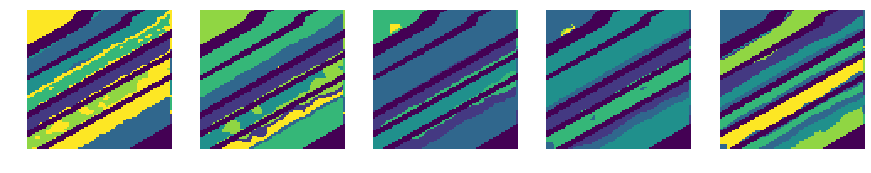

In [5]:
k = 330
L = 3
t = 5000
eps = 0.01
tilesizes = [3, 5, 7, 9, 11]
dictionaries = []
for ts in tilesizes:
    dictionaries.append(np.load('results/JSR/salinas_k%d_L%d_t%d_eps001_ts%d.npy'%(k, L, t, ts)))

clusterings = []
for i in range(len(dictionaries)):
    clusterings.append(js_clustering(dictionary=dictionaries[i], image=salinas_image, gt=salinas_gt, L=L, tilesize=tilesizes[i], eps=eps))

f, ax = plt.subplots(1, len(clusterings), figsize=(15,15))
for i in range(len(clusterings)):
    ax[i].imshow(clusterings[i])
    ax[i].axis('off')

plt.savefig('JSR_Result.jpg')
plt.show()